In [7]:
# -----------------------------------------------------
# Step 1: Import Libraries
# -----------------------------------------------------
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from statsmodels.discrete.discrete_model import Probit
from lifelines import CoxPHFitter
from lifelines.utils import to_episodic_format
import warnings
warnings.filterwarnings("ignore")

In [8]:
# -----------------------------------------------------
# Step 2: Load Data (update the path if needed)
# -----------------------------------------------------
df = pd.read_csv("D:\\Masters\\VCU\\Classes\\SCMA\\R\\A1\\Ref\\NSSO68.csv", low_memory=False)

In [4]:
# Create the nonveg_flag column again in case it was lost
df["nonveg_flag"] = ((df["fishprawn_v"] > 0) | (df["goatmeat_v"] > 0) |
                     (df["beef_v"] > 0) | (df["pork_v"] > 0) |
                     (df["chicken_v"] > 0) | (df["othrbirds_v"] > 0)).astype(int)

# Select variables as done in R code
df_model = df[["nonveg_flag", "Age", "Sex", "Religion", "Social_Group", "MPCE_MRP"]].dropna()
df_model[["Sex", "Religion", "Social_Group"]] = df_model[["Sex", "Religion", "Social_Group"]].astype("category")

# Balance the classes
min_class_size = df_model["nonveg_flag"].value_counts().min()
df_balanced = df_model.groupby("nonveg_flag").sample(n=min_class_size, random_state=123)

# Train-test split
train, test = train_test_split(df_balanced, test_size=0.3, stratify=df_balanced["nonveg_flag"], random_state=123)

Optimization terminated successfully.
         Current function value: 0.609522
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:            nonveg_flag   No. Observations:                50748
Model:                          Logit   Df Residuals:                    50735
Method:                           MLE   Df Model:                           12
Date:                Mon, 30 Jun 2025   Pseudo R-squ.:                  0.1206
Time:                        15:53:35   Log-Likelihood:                -30932.
converged:                       True   LL-Null:                       -35176.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0042      0.046      0.092      0.927      -0.086       0.094
Age        

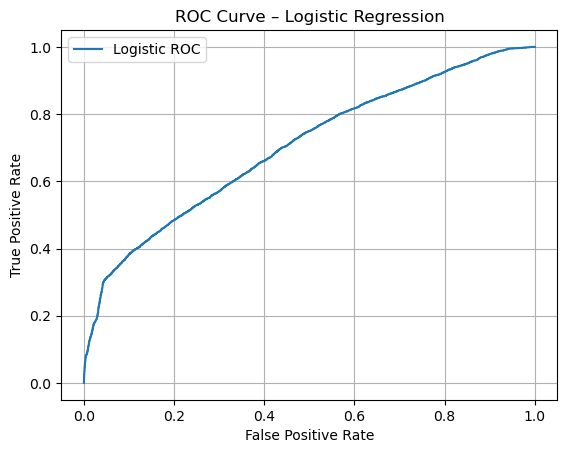

In [5]:
# Convert target to numeric
train["nonveg_flag"] = train["nonveg_flag"].astype(int)
test["nonveg_flag"] = test["nonveg_flag"].astype(int)

# Separate predictors and response
y_train = train["nonveg_flag"]
y_test = test["nonveg_flag"]

# One-hot encode and align
X_train = pd.get_dummies(train.drop("nonveg_flag", axis=1), drop_first=True)
X_test = pd.get_dummies(test.drop("nonveg_flag", axis=1), drop_first=True)
X_train, X_test = X_train.align(X_test, join="left", axis=1, fill_value=0)

# Drop duplicate and constant columns
X_train = X_train.loc[:, ~X_train.T.duplicated()]
X_train = X_train.loc[:, X_train.nunique() > 1]
X_test = X_test[X_train.columns]

# Add constant after cleanup
X_train = sm.add_constant(X_train, has_constant='add')
X_test = sm.add_constant(X_test, has_constant='add')

# Convert all to float
X_train = X_train.astype(float)
X_test = X_test.astype(float)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# Fit logistic model safely
logit_model = sm.Logit(y_train, X_train).fit()
print(logit_model.summary())

# Predict and classify
prob_logit = logit_model.predict(X_test)
pred_logit = (prob_logit > 0.5).astype(int)

# Evaluation
print(confusion_matrix(y_test, pred_logit))
print(classification_report(y_test, pred_logit))
print("AUC (Logit):", roc_auc_score(y_test, prob_logit))

# ROC Plot
fpr, tpr, _ = roc_curve(y_test, prob_logit)
plt.plot(fpr, tpr, label="Logistic ROC")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Logistic Regression")
plt.grid()
plt.legend()
plt.show()

Optimization terminated successfully.
         Current function value: 0.609604
         Iterations 7
                          Probit Regression Results                           
Dep. Variable:            nonveg_flag   No. Observations:                50748
Model:                         Probit   Df Residuals:                    50735
Method:                           MLE   Df Model:                           12
Date:                Mon, 30 Jun 2025   Pseudo R-squ.:                  0.1205
Time:                        15:53:40   Log-Likelihood:                -30936.
converged:                       True   LL-Null:                       -35176.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0074      0.028     -0.266      0.790      -0.062       0.047
Age        

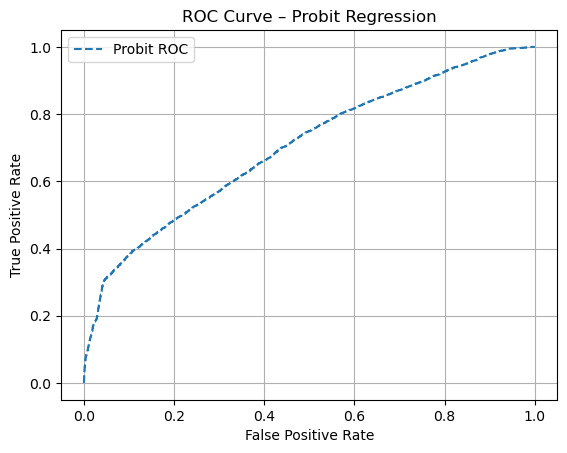

In [6]:
# PART B – Probit Regression

# Fit Probit model using the same X_train and y_train
probit_model = sm.Probit(y_train, X_train).fit()
print(probit_model.summary())

# Predict probabilities and classify
prob_probit = probit_model.predict(X_test)
pred_probit = (prob_probit > 0.5).astype(int)

# Evaluation
print(confusion_matrix(y_test, pred_probit))
print(classification_report(y_test, pred_probit))
print("AUC (Probit):", roc_auc_score(y_test, prob_probit))

# ROC Plot
fpr_p, tpr_p, _ = roc_curve(y_test, prob_probit)
plt.plot(fpr_p, tpr_p, label="Probit ROC", linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve – Probit Regression")
plt.grid()
plt.legend()
plt.show()


<lifelines.CoxPHFitter: fitted with 101646 total observations, 36249 right-censored observations>
             duration col = 'duration'
                event col = 'event_observed'
      baseline estimation = breslow
   number of observations = 101646
number of events observed = 65397
   partial log-likelihood = -648806.39
         time fit was run = 2025-06-30 10:25:56 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
Age              -0.01      0.99      0.00           -0.01           -0.00                0.99                1.00
MPCE_MRP         -0.00      1.00      0.00           -0.00           -0.00                1.00                1.00
Sex_2            -0.15      0.86      0.01           -0.18           -0.13                0.84                0.88
Religion_2.0     -0.31      0.73      0.01           -0.33           -0.29                0.72                0.75
Religion_3.0     -0.50      0.61      0.02           -0.53           -0.47                0.59                0.62
Religion_4.0      0.89      2.42      0.05            0.78            0.99                2.18                2.69
Religion_5.0      0.04      1.05      0.26           -0.46            0.55                0.63                1.73
Religion_6.0     -0.09      0.91      0.03           -0.16           -0.02                0.86                0.98
Religion_7.0      9.36  11588.67      1.00            7.39           11.33             1618.52            82975.30
Religion_9.0     -0.39      0.68      0.04           -0.46           -0.32                0.63                0.73
Social_Group_2.0  0.20      1.22      0.02            0.17            0.23                1.18                1.26
Social_Group_3.0  0.20      1.22      0.01            0.17            0.22                1.18                1.25
Social_Group_9.0  0.05      1.05      0.01            0.02            0.08                1.02                1.08

                  cmp to       z      p  -log2(p)
covariate                                        
Age                 0.00  -16.18 <0.005    193.23
MPCE_MRP            0.00 -106.14 <0.005       inf
Sex_2               0.00  -12.29 <0.005    112.96
Religion_2.0        0.00  -28.81 <0.005    603.82
Religion_3.0        0.00  -32.22 <0.005    754.03
Religion_4.0        0.00   16.54 <0.005    201.76
Religion_5.0        0.00    0.17   0.86      0.21
Religion_6.0        0.00   -2.66   0.01      6.98
Religion_7.0        0.00    9.32 <0.005     66.18
Religion_9.0        0.00  -11.09 <0.005     92.45
Social_Group_2.0    0.00   12.62 <0.005    118.87
Social_Group_3.0    0.00   14.31 <0.005    151.86
Social_Group_9.0    0.00    3.61 <0.005     11.67
---
Concordance = 0.71
Partial AIC = 1297638.79
log-likelihood ratio test = 21880.31 on 13 df
-log2(p) of ll-ratio test = inf

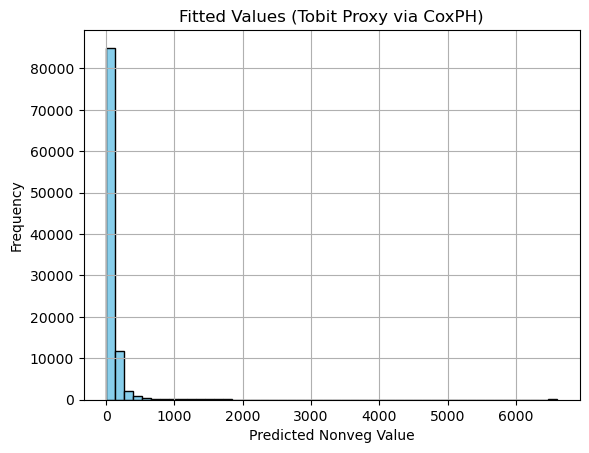

In [10]:
# Create nonveg_value column (total value of all nonveg items)
df["nonveg_value"] = (
    df["fishprawn_v"].fillna(0) +
    df["goatmeat_v"].fillna(0) +
    df["beef_v"].fillna(0) +
    df["pork_v"].fillna(0) +
    df["chicken_v"].fillna(0) +
    df["othrbirds_v"].fillna(0)
)

# Prepare Tobit data
df_tobit = df[["nonveg_value", "Age", "Sex", "Religion", "Social_Group", "MPCE_MRP"]].dropna()

# Convert categorical variables
df_tobit["Sex"] = df_tobit["Sex"].astype("category")
df_tobit["Religion"] = df_tobit["Religion"].astype("category")
df_tobit["Social_Group"] = df_tobit["Social_Group"].astype("category")

# One-hot encode
df_tobit_encoded = pd.get_dummies(df_tobit, drop_first=True)

# Apply left-censoring at zero
df_tobit_encoded["event_observed"] = (df_tobit_encoded["nonveg_value"] > 0).astype(int)
df_tobit_encoded["duration"] = df_tobit_encoded["nonveg_value"]  # required for lifelines

# Drop original nonveg_value
df_tobit_encoded = df_tobit_encoded.drop(columns=["nonveg_value"])

# Fit Cox Proportional Hazards model as Tobit proxy
cph = CoxPHFitter()
cph.fit(df_tobit_encoded, duration_col="duration", event_col="event_observed")
cph.print_summary()

# Predicted values (risk scores as proxy)
fitted_values = cph.predict_expectation(df_tobit_encoded)

plt.hist(fitted_values, bins=50, color="skyblue", edgecolor="black")
plt.title("Fitted Values (Tobit Proxy via CoxPH)")
plt.xlabel("Predicted Nonveg Value")
plt.ylabel("Frequency")
plt.grid()
plt.show()